# Linear Regression

In [12]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [ ]:
import pandas as pd
import numpy as np
import plotly.express as px
import os
import polars as pl
from IPython.display import display, HTML
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix

In [14]:
import matplotlib.pyplot as plt

In [15]:
# Load the skaters dataset
skaters_df = pd.read_excel("../DataCleaning/Instat_DataCleaning/SkatersCleaned.xlsx")

# Display the DataFrame as a scrollable HTML table
display(HTML(skaters_df.to_html(index=False, max_rows=5, max_cols=None)))

Shirt number,Player,Position,Games played,All shifts,Goals,First assist,Second assist,Assists,Points,+/-,Scoring chances,Penalties drawn,Faceoffs,Faceoffs won,"Faceoffs won, %",Hits,Shots,Shots on goal,Blocked shots,Power play shots,Short-handed shots,Passes to the slot,Faceoffs in DZ,Faceoffs won in DZ,"Faceoffs won in DZ, %",Faceoffs in NZ,Faceoffs won in NZ,"Faceoffs won in NZ, %",Faceoffs in OZ,Faceoffs won in OZ,"Faceoffs won in OZ, %",Puck touches,Plus,Minus,Penalties,Faceoffs lost,Hits against,Error leading to goal,Dump ins,Dump outs,Team goals when on ice,Opponent's goals when on ice,Power play,Successful power play,Short-handed,Penalty killing,Missed shots,% shots on goal,Slapshot,Wrist shot,Shootouts,Shootouts scored,Shootouts missed,1-on-1 shots,1-on-1 goals,"Shots conversion 1 on 1, %",Positional attack shots,Shots 5 v 5,Counter-attack shots,xG per shot,xG (Expected goals),xG per goal,Net xG (xG player on - opp. team's xG),Team xG when on ice,Opponent's xG when on ice,xG conversion,CORSI,CORSI-,CORSI+,"CORSI for, %",Fenwick for,Fenwick against,"Fenwick for, %",Puck battles,Puck battles won,"Puck battles won, %",Puck battles in DZ,Puck battles in NZ,Puck battles in OZ,Shots blocking,Dekes,Dekes successful,Dekes unsuccessful,"Dekes successful, %",Passes,Accurate passes,"Accurate passes, %",Pre-shots passes,Pass receptions,Scoring chances - total,Scoring chances - scored,Scoring chances missed,Scoring chances saved,"Scoring Chances, %",Inner slot shots - total,Inner slot shots - scored,Inner slot shots - missed,Inner slot shots - saved,"Inner slot shots, %",Outer slot shots - total,Outer slot shots - scored,Outer slot shots - missed,Outer slot shots - saved,"Outer slot shots, %",Blocked shots from the slot,Blocked shots outside of the slot,Takeaways,Puck retrievals after shots,Opponent’s dump-in retrievals,Takeaways in DZ,Loose puck recovery,Takeaways in NZ,Takeaways in OZ,EV DZ retrievals,Puck losses,Puck losses in DZ,EV OZ retrievals,Puck losses in NZ,Power play retrievals,Penalty kill retrievals,Puck losses in OZ,Entries,Entries via pass,Entries via dump in,Entries via stickhandling,Breakouts,Breakouts via pass,Breakouts via dump out,Breakouts via stickhandling,National team,Height,Weight,Contract,Active hand,Type,Time on ice_minutes,Time on ice_seconds,Penalty time_minutes,Penalty time_seconds,Puck control time_minutes,Puck control time_seconds,Power play time_minutes,Power play time_seconds,Short-handed time_minutes,Short-handed time_seconds,Playing in attack_minutes,Playing in attack_seconds,Playing in defense_minutes,Playing in defense_seconds,OZ possession_minutes,OZ possession_seconds,NZ possession_minutes,NZ possession_seconds,DZ possession_minutes,DZ possession_seconds
6,Alyssa Wilson,F,23,17.0,0.04,0.04,0.04,0.09,0.13,-1.04,0.04,0.04,0.09,0.04,0.50,0.13,2.00,0.74,0.61,0.00,0.0,0.17,0.04,0.04,1.00,0.04,0.00,0.00,0.0,0.00,0.00,57.0,0.22,1.26,0.17,0.04,0.04,0.96,1.61,1.96,0.22,1.26,0.00,0.00,0.00,0.00,0.65,0.37,0.74,0.87,0.0,0.0,0.0,0.00,0.0,0.0,1.17,2.00,0.04,0.31,0.05,0.29,-0.75,0.46,1.22,0.0091,-8.0,18,10.0,0.35,7.0,14.0,0.35,10.0,5.2,0.54,7.0,1.61,1.39,0.78,0.26,0.22,0.04,0.83,12.0,10.0,0.83,0.22,6.0,0.26,0.04,0.04,0.17,0.17,0.04,0.04,0.00,0.00,1.0,0.22,0.0,0.04,0.17,0.0,0.00,0.61,7.0,1.87,1.09,5.20,1.48,1.61,0.39,1.39,4.20,1.30,0.48,1.04,0.00,0.00,1.87,1.48,0.52,0.22,0.74,2.30,1.48,0.13,0.70,0,0,0.0,0,Right,Even Strength,15,20,0,26,0,16,0,0,0,0,6,15,7,7,4,56,3,8,7,16
12,Ella Bynan,F,24,16.0,0.00,0.08,0.13,0.21,0.21,-0.58,0.38,0.13,9.00,4.30,0.48,0.00,1.54,1.17,0.21,0.00,0.0,0.25,3.80,1.79,0.47,2.80,1.38,0.49,2.4,1.17,0.48,55.0,0.21,0.79,0.04,4.70,0.04,0.08,1.79,0.50,0.21,0.79,0.00,0.00,0.00,0.00,0.17,0.76,0.54,0.38,0.0,0.0,0.0,0.00,0.0,0.0,0.50,1.54,0.08,1.33,0.12,0.00,-0.60,0.43,1.03,0.0000,-7.0,17,9.0,0.36,7.0,13.0,0.35,14.0,5.9,0.42,6.0,2.00,5.70,0.92,0.63,0.42,0.21,0.67,9.0,7.0,0.71,0.29,8.0,0.71,0.00,0.08,0.63,0.00,0.38,0.00,0.04,0.33,0.0,0.33,0.0,0.04,0.29,0.0,0.00,0.21,3.4,1.04,0.04,2.50,0.21,0.67

In [16]:
# Drop unneeded columns
skaters_df.drop(['Player', 'Contract'], axis=1, inplace=True)

# Find remaining categorical columns and one‐hot encode them
cat_cols = skaters_df.select_dtypes(include=['object']).columns.tolist()
skaters_df = pd.get_dummies(skaters_df, columns=cat_cols)

display(HTML(skaters_df.to_html(index=False, max_rows=5, max_cols=None)))

Shirt number,Games played,All shifts,Goals,First assist,Second assist,Assists,Points,+/-,Scoring chances,Penalties drawn,Faceoffs,Faceoffs won,"Faceoffs won, %",Hits,Shots,Shots on goal,Blocked shots,Power play shots,Short-handed shots,Passes to the slot,Faceoffs in DZ,Faceoffs won in DZ,"Faceoffs won in DZ, %",Faceoffs in NZ,Faceoffs won in NZ,"Faceoffs won in NZ, %",Faceoffs in OZ,Faceoffs won in OZ,"Faceoffs won in OZ, %",Puck touches,Plus,Minus,Penalties,Faceoffs lost,Hits against,Error leading to goal,Dump ins,Dump outs,Team goals when on ice,Opponent's goals when on ice,Power play,Successful power play,Short-handed,Penalty killing,Missed shots,% shots on goal,Slapshot,Wrist shot,Shootouts,Shootouts scored,Shootouts missed,1-on-1 shots,1-on-1 goals,"Shots conversion 1 on 1, %",Positional attack shots,Shots 5 v 5,Counter-attack shots,xG per shot,xG (Expected goals),xG per goal,Net xG (xG player on - opp. team's xG),Team xG when on ice,Opponent's xG when on ice,xG conversion,CORSI,CORSI-,CORSI+,"CORSI for, %",Fenwick for,Fenwick against,"Fenwick for, %",Puck battles,Puck battles won,"Puck battles won, %",Puck battles in DZ,Puck battles in NZ,Puck battles in OZ,Shots blocking,Dekes,Dekes successful,Dekes unsuccessful,"Dekes successful, %",Passes,Accurate passes,"Accurate passes, %",Pre-shots passes,Pass receptions,Scoring chances - total,Scoring chances - scored,Scoring chances missed,Scoring chances saved,"Scoring Chances, %",Inner slot shots - total,Inner slot shots - scored,Inner slot shots - missed,Inner slot shots - saved,"Inner slot shots, %",Outer slot shots - total,Outer slot shots - scored,Outer slot shots - missed,Outer slot shots - saved,"Outer slot shots, %",Blocked shots from the slot,Blocked shots outside of the slot,Takeaways,Puck retrievals after shots,Opponent’s dump-in retrievals,Takeaways in DZ,Loose puck recovery,Takeaways in NZ,Takeaways in OZ,EV DZ retrievals,Puck losses,Puck losses in DZ,EV OZ retrievals,Puck losses in NZ,Power play retrievals,Penalty kill retrievals,Puck losses in OZ,Entries,Entries via pass,Entries via dump in,Entries via stickhandling,Breakouts,Breakouts via pass,Breakouts via dump out,Breakouts via stickhandling,National team,Height,Weight,Time on ice_minutes,Time on ice_seconds,Penalty time_minutes,Penalty time_seconds,Puck control time_minutes,Puck control time_seconds,Power play time_minutes,Power play time_seconds,Short-handed time_minutes,Short-handed time_seconds,Playing in attack_minutes,Playing in attack_seconds,Playing in defense_minutes,Playing in defense_seconds,OZ possession_minutes,OZ possession_seconds,NZ possession_minutes,NZ possession_seconds,DZ possession_minutes,DZ possession_seconds,Position_D,Position_F,Active hand_Left,Active hand_Right,Type_Even Strength,Type_Penalty Kill,Type_Power Play,Type_Total
6,23,17.0,0.04,0.04,0.04,0.09,0.13,-1.04,0.04,0.04,0.09,0.04,0.50,0.13,2.00,0.74,0.61,0.00,0.0,0.17,0.04,0.04,1.00,0.04,0.00,0.00,0.0,0.00,0.00,57.0,0.22,1.26,0.17,0.04,0.04,0.96,1.61,1.96,0.22,1.26,0.00,0.00,0.00,0.00,0.65,0.37,0.74,0.87,0.0,0.0,0.0,0.00,0.0,0.0,1.17,2.00,0.04,0.31,0.05,0.29,-0.75,0.46,1.22,0.0091,-8.0,18,10.0,0.35,7.0,14.0,0.35,10.0,5.2,0.54,7.0,1.61,1.39,0.78,0.26,0.22,0.04,0.83,12.0,10.0,0.83,0.22,6.0,0.26,0.04,0.04,0.17,0.17,0.04,0.04,0.00,0.00,1.0,0.22,0.0,0.04,0.17,0.0,0.00,0.61,7.0,1.87,1.09,5.20,1.48,1.61,0.39,1.39,4.20,1.30,0.48,1.04,0.00,0.00,1.87,1.48,0.52,0.22,0.74,2.30,1.48,0.13,0.70,0,0,0.0,15,20,0,26,0,16,0,0,0,0,6,15,7,7,4,56,3,8,7,16,False,True,False,True,True,False,False,False
12,24,16.0,0.00,0.08,0.13,0.21,0.21,-0.58,0.38,0.13,9.00,4.30,0.48,0.00,1.54,1.17,0.21,0.00,0.0,0.25,3.80,1.79,0.47,2.80,1.38,0.49,2.4,1.17,0.48,55.0,0.21,0.79,0.04,4.70,0.04,0.08,1.79,0.50,0.21,0.79,0.00,0.00,0.00,0.00,0.17,0.76,0.54,0.38,0.0,0.0,0.0,0.00,0.0,0.0,0.50,1.54,0.08,1.33,0.12,0.00,-0.60,0.43,1.03,0.0000,-7.0,17,9.0,0.36,7.0,13.0,0.35,14.0,5.9,0.42,6.0,2.00,5.70,0.92,0.63,0.42,0.21,0.67,9.0,7.0,0.71,0.29,8.0,0.71,0.00,0.08,0.63,0.00,0.38,0.00,0.

## Linear Regression based on Goals

In [17]:
# Prepare data for linear regression
# Define target and columns to drop
target = "Goals"
drop_cols = [
    target,
    "Points",
    "Scoring chances",
    "Shots conversion 1 on 1, %",
    "Inner slot shots - scored",
    "Outer slot shots - scored",
    "xG per goal",
    "+/-",
    "Team goals when on ice",
    "Plus"
]

# Features and target
X = skaters_df.drop(columns=drop_cols, errors="ignore")
y = skaters_df[target]

# Set up cross‐validation and model
kf = KFold(n_splits=5, shuffle=True, random_state=42)
model = LinearRegression()

# Evaluate with MSE
mse_scores = -cross_val_score(model, X, y, cv=kf, scoring="neg_mean_squared_error")
print(f"CV mean MSE: {mse_scores.mean():.4f}")

# Train final model on all data
model.fit(X, y)
print("Coefficients:", dict(zip(X.columns, model.coef_)))

CV mean MSE: 0.0027
Coefficients: {'Shirt number': -4.299678667516404e-05, 'Games played': 0.00020235130246993552, 'All shifts': 0.007778322952397882, 'First assist': -0.016411643379565452, 'Second assist': -0.01757881771464436, 'Assists': -0.033712950334950254, 'Penalties drawn': -0.03755367288261262, 'Faceoffs': -0.03888655887912685, 'Faceoffs won': 0.032847550518935065, 'Faceoffs won, %': -0.02426023486775193, 'Hits': -0.023912096677767763, 'Shots': 0.007577774533389753, 'Shots on goal': 0.004098395584250467, 'Blocked shots': -0.005827858314688418, 'Power play shots': 0.01201824784896841, 'Short-handed shots': -0.02569159622666382, 'Passes to the slot': -0.02907962273530717, 'Faceoffs in DZ': 0.026011542068651392, 'Faceoffs won in DZ': 0.02911267994933968, 'Faceoffs won in DZ, %': 0.012918870596930664, 'Faceoffs in NZ': 0.01064243241880269, 'Faceoffs won in NZ': 0.004078574024437381, 'Faceoffs won in NZ, %': -0.008996381241230422, 'Faceoffs in OZ': -0.0019199652795825698, 'Faceoffs 

In [18]:
# Create a DataFrame to display coefficients
coef_df = pd.DataFrame({'Feature': X.columns, 'Coefficient': model.coef_})

# Sort the DataFrame by absolute coefficient value
coef_df['Absolute Coefficient'] = abs(coef_df['Coefficient'])
coef_df = coef_df.sort_values(by='Absolute Coefficient', ascending=False)

# Get the top N coefficients
top_coef_df = coef_df.head(10).copy()

print(top_coef_df)

                          Feature  Coefficient  Absolute Coefficient
48        Positional attack shots    -0.083702              0.083702
101               Takeaways in OZ     0.072780              0.072780
127       Power play time_minutes    -0.065636              0.065636
81       Scoring chances - scored     0.060813              0.060813
42                     Wrist shot     0.050856              0.050856
80        Scoring chances - total     0.049697              0.049697
106             Puck losses in NZ    -0.048496              0.048496
34   Opponent's goals when on ice     0.048391              0.048391
114                     Breakouts     0.047157              0.047157
85       Inner slot shots - total     0.045439              0.045439


In [19]:
# Get coefficients and their corresponding column names
coefficients = model.coef_
column_names = X.columns

# Create a DataFrame to display coefficients
coef_df = pd.DataFrame({'Feature': column_names, 'Coefficient': coefficients})

# Sort the DataFrame by absolute coefficient value
coef_df['Absolute Coefficient'] = abs(coef_df['Coefficient'])
coef_df = coef_df.sort_values(by='Absolute Coefficient', ascending=False)

# Print the top N coefficients
N = 10  # Number of top coefficients to display
print(f"Top {N} coefficients:")
print(coef_df[['Feature', 'Coefficient']].head(N))

Top 10 coefficients:
                          Feature  Coefficient
48        Positional attack shots    -0.083702
101               Takeaways in OZ     0.072780
127       Power play time_minutes    -0.065636
81       Scoring chances - scored     0.060813
42                     Wrist shot     0.050856
80        Scoring chances - total     0.049697
106             Puck losses in NZ    -0.048496
34   Opponent's goals when on ice     0.048391
114                     Breakouts     0.047157
85       Inner slot shots - total     0.045439


                            OLS Regression Results                            
Dep. Variable:                  Goals   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                     1958.
Date:                Tue, 29 Apr 2025   Prob (F-statistic):           7.99e-20
Time:                        16:22:45   Log-Likelihood:                 343.59
No. Observations:                  64   AIC:                            -585.2
Df Residuals:                      13   BIC:                            -475.1
Df Model:                          50                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const         

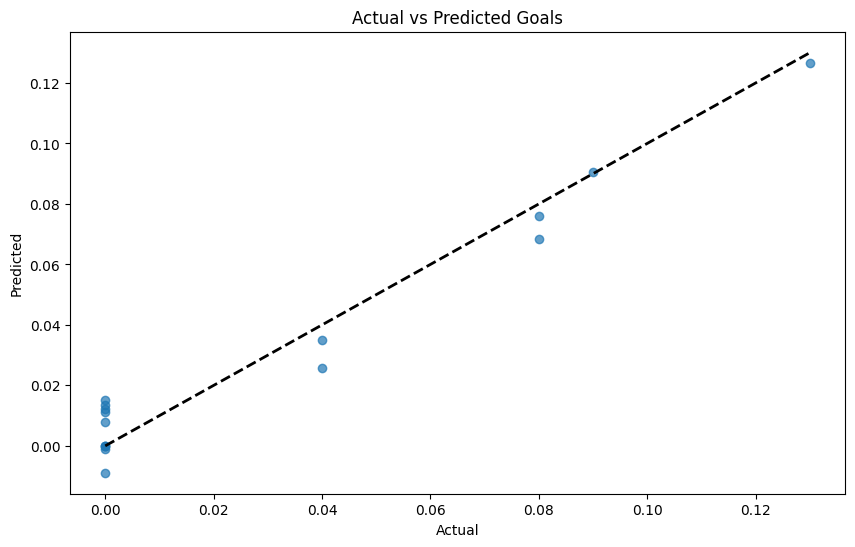

In [20]:
from sklearn.model_selection import train_test_split

import statsmodels.api as sm

# Select the top N features based on absolute coefficient values
N = 50  # You can adjust the number of top features to use
top_features = coef_df.head(N)['Feature'].tolist()

# Prepare the data using only the top features
X_top = X[top_features]

# Add a constant to the independent variables
X_top = sm.add_constant(X_top)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_top, y, test_size=0.2, random_state=42)

# Train the multiple linear regression model
model = sm.OLS(y_train, X_train).fit()

# Print the model summary
print(model.summary())

# Make predictions on the test set
y_pred = model.predict(X_test)

# Create a DataFrame for actual vs predicted values
predictions_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})

# Plotting actual vs predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.7)
plt.plot(
    [y_test.min(), y_test.max()],
    [y_test.min(), y_test.max()],
    'k--',
    lw=2
)  # Diagonal line
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted Goals')
plt.show()

In [21]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# Select the top N features based on absolute coefficient values
N = 5  # You can adjust the number of top features to use
top_features = coef_df.head(N)['Feature'].tolist()

# Prepare the data using only the top features
X_top = X[top_features]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_top, y, test_size=0.2, random_state=42)

# Train a linear regression model
model_top = LinearRegression()
model_top.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model_top.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error on the test set: {mse:.4f}")

# Display the predictions vs actual values
predictions_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
print(predictions_df)

Mean Squared Error on the test set: 0.0001
    Actual  Predicted
30    0.00  -0.002676
0     0.04   0.055112
22    0.08   0.072335
31    0.00  -0.002285
18    0.00   0.004031
28    0.00  -0.002322
10    0.00   0.001997
70    0.00   0.006878
4     0.13   0.124003
12    0.00   0.000935
49    0.00   0.002896
33    0.00  -0.002285
67    0.09   0.099754
35    0.00  -0.001064
68    0.08   0.090845
45    0.04   0.009301


In [22]:
# Create a Coefficient Magnitude Plot
top_coef_df['Magnitude'] = top_coef_df['Coefficient'].abs()

fig = px.scatter(
    top_coef_df,
    x='Coefficient',
    y='Feature',
    size='Magnitude',
    color='Coefficient',
    hover_data=['Coefficient', 'Magnitude'],
    title='Coefficient Magnitude Plot',
    labels={'Coefficient': 'Coefficient Value', 'Feature': 'Feature'},
    color_continuous_scale=px.colors.diverging.RdBu
)

fig.update_layout(
    xaxis_title="Coefficient Value",
    yaxis_title="Feature",
    title_x=0.5,
    height=600,
    width=800
)

fig.show()

In [23]:
# Create a bar graph of the top coefficients
top_coef_df = coef_df.head(N)

fig = px.bar(
    top_coef_df,
    x='Feature',
    y='Coefficient',
    title=f'Top {N} Coefficients Influencing Goals',
    labels={'Coefficient': 'Coefficient Value', 'Feature': 'Feature'}
)

fig.show()

In [24]:
# Find and print NaN values
nan_counts = skaters_df.isna().sum()
print("NaN value counts per column:")
print(nan_counts[nan_counts > 0])

NaN value counts per column:
Series([], dtype: int64)


## Linear Regression based on Points

In [25]:
# Prepare data for linear regression
# Define target and columns to drop
target = "Points"
drop_cols = [
    target,
    "Scoring chances",
    "Shots conversion 1 on 1, %",
    "Inner slot shots - scored",
    "Outer slot shots - scored",
    "xG per goal",
    "+/-",
    "Team goals when on ice",
    "Plus"
]

# Features and target
X = skaters_df.drop(columns=drop_cols, errors="ignore")
y = skaters_df[target]

# Set up cross‐validation and model
kf = KFold(n_splits=5, shuffle=True, random_state=42)
model = LinearRegression()

# Evaluate with MSE
mse_scores = -cross_val_score(model, X, y, cv=kf, scoring="neg_mean_squared_error")
print(f"CV mean MSE: {mse_scores.mean():.4f}")

# Train final model on all data
model.fit(X, y)
print("Coefficients:", dict(zip(X.columns, model.coef_)))

CV mean MSE: 0.0050
Coefficients: {'Shirt number': -0.000126124218397683, 'Games played': 0.00024038618768683524, 'All shifts': 0.011497095715735792, 'Goals': 0.03432069070117818, 'First assist': 0.01876573837581936, 'Second assist': 0.017100381475275088, 'Assists': 0.036233011428843484, 'Penalties drawn': -0.06242539252290684, 'Faceoffs': 0.0030877289964396475, 'Faceoffs won': -0.01763790272897977, 'Faceoffs won, %': 0.006178262494553774, 'Hits': -0.014413091888917314, 'Shots': 0.011420109706501503, 'Shots on goal': 0.01557463939268489, 'Blocked shots': -0.053368458639540484, 'Power play shots': -0.008304556392416965, 'Short-handed shots': 0.007190448388424135, 'Passes to the slot': -0.0061689287836996665, 'Faceoffs in DZ': 0.011088119890256709, 'Faceoffs won in DZ': -0.0011234858645189742, 'Faceoffs won in DZ, %': 0.015809669604070244, 'Faceoffs in NZ': -0.020018603297081616, 'Faceoffs won in NZ': 0.006175321757232274, 'Faceoffs won in NZ, %': -0.025719126116611646, 'Faceoffs in OZ':

In [26]:
# Get coefficients and their corresponding column names
coefficients = model.coef_
column_names = X.columns

# Create a DataFrame to display coefficients
coef_df = pd.DataFrame({'Feature': column_names, 'Coefficient': coefficients})

# Sort the DataFrame by absolute coefficient value
coef_df['Absolute Coefficient'] = abs(coef_df['Coefficient'])
coef_df = coef_df.sort_values(by='Absolute Coefficient', ascending=False)

# Print the top N coefficients
N = 10  # Number of top coefficients to display
print(f"Top {N} coefficients:")
print(coef_df[['Feature', 'Coefficient']].head(N))

Top 10 coefficients:
                               Feature  Coefficient
102                    Takeaways in OZ     0.089414
85                  Scoring Chances, %     0.075718
7                      Penalties drawn    -0.062425
128            Power play time_minutes    -0.059347
14                       Blocked shots    -0.053368
42                            Slapshot     0.052756
95   Blocked shots outside of the slot    -0.045028
70                  Puck battles in OZ     0.044696
111                            Entries     0.041623
118        Breakouts via stickhandling    -0.039184


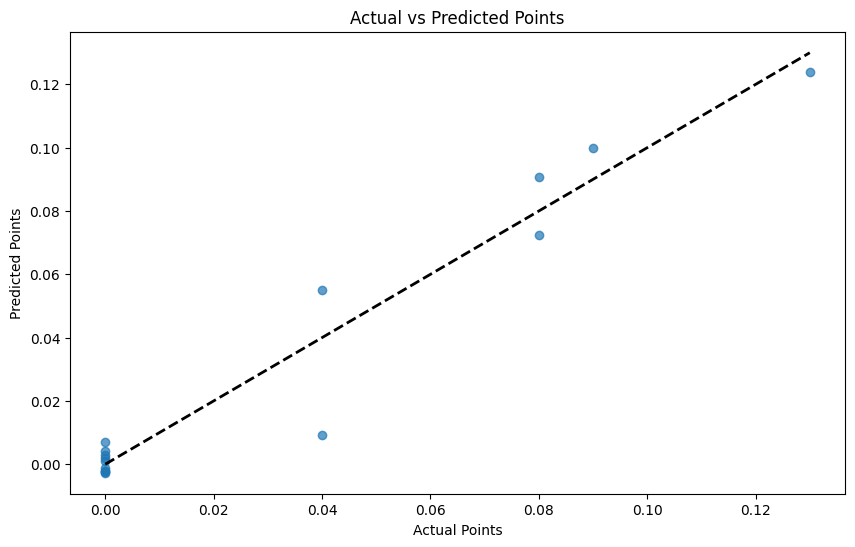

In [30]:
# Create a DataFrame for actual vs predicted values
predictions_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})

# Plotting actual vs predicted values
plt.figure(figsize=(10, 6))
plt.scatter(predictions_df['Actual'], predictions_df['Predicted'], alpha=0.7)
plt.plot(
    [predictions_df['Actual'].min(), predictions_df['Actual'].max()],
    [predictions_df['Actual'].min(), predictions_df['Actual'].max()],
    'k--',
    lw=2
)  # Diagonal line
plt.xlabel('Actual Points')
plt.ylabel('Predicted Points')
plt.title('Actual vs Predicted Points')
plt.show()